In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.
# Основные шаги:
1. Загрузите данные, путь к файлу: `/datasets/autos.csv`.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах.Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку `LightGBM` и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.
```del features_train ```
# **Описание данных**
Данные находятся в файле `/datasets/autos.csv`.
## Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

## Целевой признак
- `Price` — цена (евро)

## Ход работы

У нас есть датафрейм, содержащиq данные об автомобилях и их цене. Для начала нам необходимо предобработать его, очистить от пропусков, аномалий и ошибок. Разделить данные на признаки и целевой признак, на выборки (тренировочную, тестовую и валидационную в соотношении 3:1:1), которые необходимо будет преобразовать (кодировка, масштабирование). 

После вышеперечисленного нам необходимо разобрать несколько моделей, которые будут прогнозировать цену, при этом необходимо рассмотреть несколько разных гиперпараметров, обязательно считать `RMSE` и времена пронозирования и обучения моделей. 

По результатам трех метрик (качество предсказания и времена) необходимо выбрать лучшую модель для предсказания цены.


Таким образом есть у нас намечается 5 этапов:

- знакомство с данными
- предобработка
- разделение на выборки с их преобразованием
- обучение моделей, выбор лучшей по `RMSE`, времени обучения и времени предсказания
- проверка лучшей модели на тестовой выборке 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import time
import phik
from phik import resources, report

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV  

## Подготовка данных
Загрузим наш датасет в переменную `df` и с помощью написанной нами функции для анализа датафреймов проанализируем его

In [5]:
df = pd.read_csv("/datasets/autos.csv")
df.name = 'autos'
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
def df_description(df, hist_needed = True, display_all_columns = True):
    print(f'Описание датафрейма \'{df.name}\'')
    print('Общая информация')
    df.info()
    print('\nДубликаты')
    if df.duplicated().sum() > 0:
        print(f'В датафрейме {df.name} {df.duplicated().sum()} дубликатов')
    else:
        print(f'В датафрейме {df.name} нет дубликатов')
    print('\nПропуски')
    msno.bar(df, figsize=(5,5), fontsize=9);
    msno.matrix(df, figsize=(5,5), fontsize=9);
    plt.show()
    print('Максимальные проценты пропусков')
    miss = df.isna().sum()*100/df.shape[0]
    display(miss.sort_values(ascending = False).head())
    # если необходимо вывести на экран гистограммы распределения данных
    if hist_needed == True:
        print('\nВиды распределений данных')
        font = {'weight' : 'bold',
        'size'   : 9}
        plt.rc('font', **font)
        df.hist(figsize=(10, 10))
        plt.show()
    # если необходимо вывести расчеты для всех столбцов
    if display_all_columns == True:
        pd.set_option('display.max_columns', None)
    
    print('\nОсновные расчеты')
    display(df.describe())
    print('\nПервые пять строчек')
    display(df.head())

Описание датафрейма 'autos'
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           3543

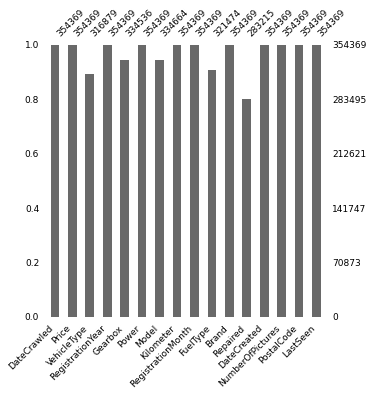

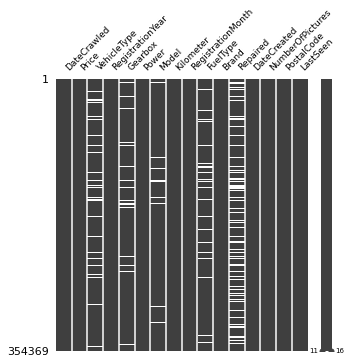

Максимальные проценты пропусков


Repaired       20.079070
VehicleType    10.579368
FuelType        9.282697
Gearbox         5.596709
Model           5.560588
dtype: float64


Виды распределений данных


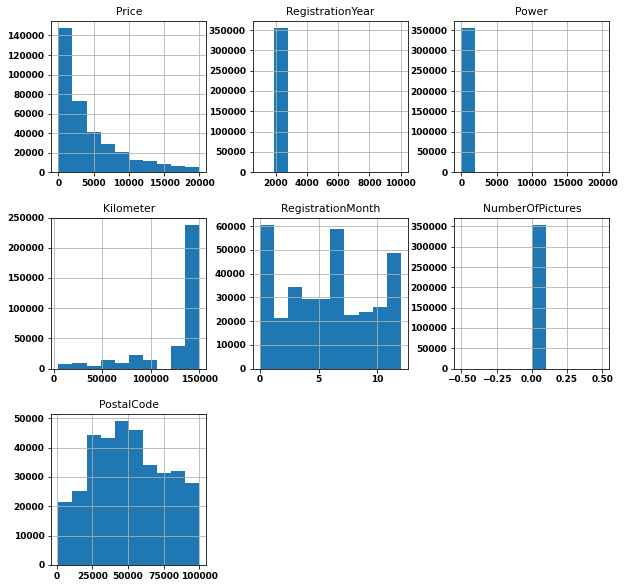


Основные расчеты


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Первые пять строчек


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df_description(df)

### Пропуски

Сначала взглянем на пропуски в данных, пропуски имеются в пяти столбцах (приведем эти столбцы вместе с процентами пропусков в них):
- Repaired -        20.08
- VehicleType -    10.58
- FuelType -        9.28
- Gearbox -         5.6
- Model -           5.56

In [8]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Давайте взглянем на столбцы с пропусками

In [9]:
df[['Repaired', 'VehicleType','FuelType','Gearbox','Model']].head(10)

,Repaired,VehicleType,FuelType,Gearbox,Model
0,NaN,NaN,petrol,manual,golf
1,yes,coupe,gasoline,manual,NaN
2,NaN,suv,gasoline,auto,grand
3,no,small,petrol,manual,golf
4,no,small,gasoline,manual,fabia
5,yes,sedan,petrol,manual,3er
6,no,convertible,petrol,manual,2_reihe
7,no,sedan,petrol,manual,other
8,NaN,bus,petrol,manual,c_max
9,NaN,small,NaN,manual,golf


Посмотрим уникальные значения столбца `Repaired`

In [10]:
display(df['Repaired'].unique())
df['Repaired'].value_counts()

array([nan, 'yes', 'no'], dtype=object)

no     247161
yes     36054
Name: Repaired, dtype: int64

Видим, что есть только "да" или "нет" в качестве статуса о том, была ли машина в ремонте или нет. Можно предположить, что отсутствие данных будет означать отсутствие ремонта машины.

Заполним пропуски в этом столбце значениями `no`

In [11]:
df['Repaired'] = df['Repaired'].fillna('no')
df['Repaired'].isna().sum()

0

Так, вопрос с наличием ремонта у машины решили, рассмотрим теперь тип автомобильного кузова

In [12]:
df.loc[df['VehicleType'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,no,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,no,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07


Рассмотрим, есть ли связь с моделью и брэндом (по идее что-то должно быть общим)

In [13]:
vehicle_type = df.groupby(['Brand','Model','VehicleType']).agg({'VehicleType':['count']})
vehicle_type.head(10)

VehicleType
                                   count
Brand      Model VehicleType            
alfa_romeo 145   coupe                 2
                 other                 1
                 sedan                13
                 small                19
           147   coupe                27
                 other                 7
                 sedan               358
                 small                97
                 suv                   1
                 wagon                 2

Как видно, тип кузова представлен самыми разными вариантами даже среди одной и той же модели машины, поэтому придется просто заполнить пустоты заглушкой. В данном случае хорошо подойдет тип кузова `unknown` - ясно и лаконично

In [14]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['VehicleType'].isna().sum()

0

Для столбца `model` получается аналогичная ситуация с невозможностью восстановления данных, поэтому заполним эти поля заглушкой `unknown`

In [15]:
df['Model'] = df['Model'].fillna('unknown')
df['Model'].isna().sum()

0

Тип кузова и модель заполнили, перейдем к пропускам в столбце с типом топлива `FuelType`. Также сгруппируем по бренду и модели машины

In [16]:
fuel_type = df[['Brand','Model','FuelType','Price']].groupby(['Brand','Model', 'FuelType']).count().reset_index()
fuel_type.head(10)

,Brand,Model,FuelType,Price
0,alfa_romeo,145,gasoline,1
1,alfa_romeo,145,petrol,43
2,alfa_romeo,147,gasoline,133
3,alfa_romeo,147,lpg,18
4,alfa_romeo,147,petrol,390
5,alfa_romeo,156,gasoline,189
6,alfa_romeo,156,lpg,15
7,alfa_romeo,156,petrol,366
8,alfa_romeo,159,gasoline,140
9,alfa_romeo,159,petrol,58


Видим, что есть разные типы топлива для моделей, но так ли это всё однозначно? Попробуем сгруппировать по типу маркам с моделями и посмотреть, какие из них включают в себя единственный вид топлива

In [17]:
fuel_type_restructured = fuel_type.groupby(['Brand', 'Model', 'FuelType']).agg({'FuelType':['count']})\
[fuel_type.groupby(['Brand', 'Model']).agg({'FuelType':['count']})['FuelType']['count'] == 1].reset_index()
fuel_type_restructured

/tmp/ipykernel_132/1290774118.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fuel_type_restructured = fuel_type.groupby(['Brand', 'Model', 'FuelType']).agg({'FuelType':['count']})\


Brand               Model  FuelType      
                                             count
0         audi                 200    petrol     1
1         audi                  90    petrol     1
2     daihatsu             charade    petrol     1
3     daihatsu             materia    petrol     1
4     daihatsu                move    petrol     1
5       jaguar             unknown    petrol     1
6       lancia          elefantino    petrol     1
7       lancia             unknown    petrol     1
8   land_rover  range_rover_evoque  gasoline     1
9         opel              kadett    petrol     1
10     porsche                 911    petrol     1
11     porsche             boxster    petrol     1
12     renault                 r19    petrol     1
13       rover            defender    petrol     1
14  volkswagen              amarok  gasoline     1

На основании этой таблицы постараемся заполнить пропуски в `FuelType` для этих марок и моделей

In [18]:
# сколько пропусков было
before = df['FuelType'].isna().sum()

In [19]:
for model in fuel_type_restructured.values:
    df.loc[(df['Model'] == model[1]) & (df['FuelType'].isna()), 'FuelType'] = model[2]

In [20]:
after = df['FuelType'].isna().sum() # сколько пропусков осталось после заполнения
print(f'Удалось заполнить {before - after} пропусков')

Удалось заполнить 7328 пропусков


Не густо, конечно, заполнили данные, но ничего не попишешь. Оставшиеся пропуски заполняем все той же затычкой `unknown`

In [21]:
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'].isna().sum()

0

Следуя той же логике постараемся по-максимуму заполнить пропуски в `Gearbox`

In [22]:
gearbox = df[['Brand','Model','Gearbox','Price']].groupby(['Brand','Model', 'Gearbox']).count().reset_index()
gearbox.head(10)

,Brand,Model,Gearbox,Price
0,alfa_romeo,145,manual,40
1,alfa_romeo,147,auto,29
2,alfa_romeo,147,manual,520
3,alfa_romeo,156,auto,45
4,alfa_romeo,156,manual,556
5,alfa_romeo,159,auto,26
6,alfa_romeo,159,manual,183
7,alfa_romeo,other,auto,32
8,alfa_romeo,other,manual,464
9,alfa_romeo,spider,auto,3


Посмотрим, есть ли модели, у которых единственный тип коробки передач

In [23]:
gearbox_restructured = gearbox.groupby(['Brand', 'Model', 'Gearbox']).agg({'Gearbox':['count']})\
[gearbox.groupby(['Brand', 'Model']).agg({'Gearbox':['count']})['Gearbox']['count'] == 1].reset_index()
gearbox_restructured

/tmp/ipykernel_132/1948057365.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gearbox_restructured = gearbox.groupby(['Brand', 'Model', 'Gearbox']).agg({'Gearbox':['count']})\


Brand               Model Gearbox      
                                              count
0      alfa_romeo                 145  manual     1
1       chevrolet               spark  manual     1
2           dacia              duster  manual     1
3           dacia               lodgy  manual     1
4           dacia               logan  manual     1
5           dacia               other  manual     1
6           dacia             unknown  manual     1
7          daewoo               matiz  manual     1
8            lada              kalina  manual     1
9            lada                niva  manual     1
10           lada              samara  manual     1
11           lada             unknown  manual     1
12         lancia          elefantino  manual     1
13     land_rover  range_rover_evoque    auto     1
14     land_rover             serie_1  manual     1
15     land_rover             serie_2  manual     1
16     land_rover             serie_3  manual     1
17  mercedes_benz                  gl    auto     1
18           mini               other  manual     1
19          rover            defender  manual     1
20          rover           discovery  manual     1
21           seat               other  manual     1
22        trabant               other  manual     1
23        trabant             unknown  manual     1
24     volkswagen                 fox  manual     1

In [24]:
# сколько пропусков было
before = df['Gearbox'].isna().sum()

In [25]:
for model in gearbox_restructured.values:
    df.loc[(df['Model'] == model[1]) & (df['Gearbox'].isna()), 'Gearbox'] = model[2]

In [26]:
after = df['Gearbox'].isna().sum() # сколько пропусков осталось после заполнения
print(f'Удалось заполнить {before - after} пропусков')

Удалось заполнить 5636 пропусков


Вполне неплохо, оставшиеся пропуски заткнем затычкой `unknown`

In [27]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Gearbox'].isna().sum()

0

Посмотрим, остались ли пропуски в нашем датафрейме

In [28]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Удалось закрыть все пропуски (там, где была возможность - на основании других данных, где нет - заглушкой `unknown`)

Рассмотрим категории в столбце `FuelType`

In [29]:
df['FuelType'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Глаз сразу цепляется за незнакомые слова:
LPG (liquefied petroleum gas) — это сжиженный пропан, CNG (compressed natural gas) — сжатый метан, а вот LNG (liquefied natural gas) тоже метан, однако сжиженный и изначально охлажденный до минус 162 градусов по Цельсию.

в остальном же получается, что у нас есть две категории, имеющие одну и ту же основу: petrol и gasoline
Заменим тогда весь gasoline на petrol

In [30]:
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')
df['FuelType'].unique()

array(['petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Поменяли, теперь, вроде, все чинно

### Дубликаты
Теперь необходимо рассмотреть дубликаты в данных

In [31]:
df.duplicated().sum()

5

У нас 5 дубликатов, ничего не случится, если мы просто от них избавимся, данных очень много

In [32]:
df = df.drop_duplicates()
df.duplicated().sum()

0

От дубликатов избавились

### Аномалии
Теперь рассмотрим выбросы в данных

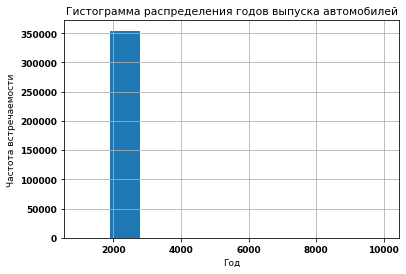

In [33]:
df.hist('RegistrationYear')
plt.xlabel('Год')
plt.ylabel('Частота встречаемости')
plt.title('Гистограмма распределения годов выпуска автомобилей')
plt.show()

Видим, что явно есть какие-то выбросы, посмотрим, сколько данных у нас с годом выпуска больше, чем 2023

In [34]:
col = df.query('RegistrationYear > 2023')['RegistrationYear'].count()
print(f'Автомобилей с годом выпуска больше, чем 2023: {col} штук')

Автомобилей с годом выпуска больше, чем 2023: 105 штук


Видим, что таких автомобилей не очень много, но они есть, избавимся от этих данных

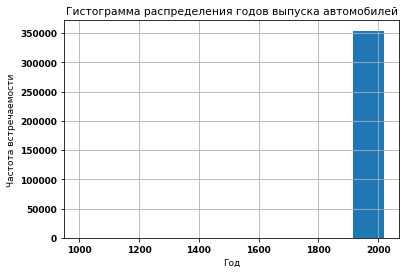

In [35]:
df = df.query('RegistrationYear <= 2023')
df.hist('RegistrationYear')
plt.xlabel('Год')
plt.ylabel('Частота встречаемости')
plt.title('Гистограмма распределения годов выпуска автомобилей')
plt.show()

Теперь видим, что и в обратную сторону что-то не то. Рассмотрим, сколько авто с годом выпуска меньше, чем, допустим, 1980

In [36]:
col = df.query('RegistrationYear < 1960')['RegistrationYear'].count()
print(f'Автомобилей с годом выпуска меньше, чем 1960: {col} штук')

Автомобилей с годом выпуска меньше, чем 1960: 422 штук


Их тоже удалим

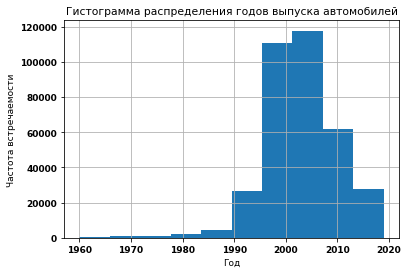

In [37]:
df = df.query('RegistrationYear >= 1960')
df.hist('RegistrationYear')
plt.xlabel('Год')
plt.ylabel('Частота встречаемости')
plt.title('Гистограмма распределения годов выпуска автомобилей')
plt.show()

Теперь годы выпуска выглядят вполне адекватно

In [38]:
df['RegistrationYear'].describe()

count    353837.000000
mean       2003.150100
std           7.226552
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [39]:
df['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 353837, dtype: object

Как видим, среднее значение года выпуска у нас в районе 2003 года.
Теперь взглянем на `Power`

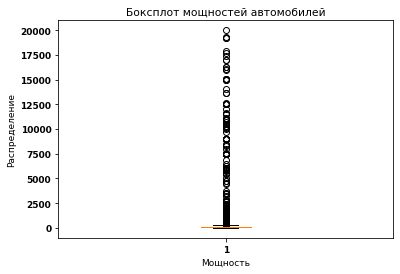

In [40]:
plt.boxplot(df['Power'])
plt.xlabel('Мощность')
plt.ylabel('Распределение')
plt.title('Боксплот мощностей автомобилей')
plt.show()

Показывает наличие большого числа выбросов, рассмотрим описание

In [41]:
df['Power'].describe()

count    353837.000000
mean        110.146367
std         189.584487
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Гугл показывает, что самая мощная машина имеет двигатель в районе 5000 л/с, самые маломощные - в районе 13-15 л/с, рассмотрим данные в пределах от 10 до 500 л/с

In [42]:
abnormal_power_count = df.query('(Power <= 10) | (Power >= 500)')['Power'].count()
print(f'Количество машин с неадекватной мощностью двигателя равно {abnormal_power_count}')

Количество машин с неадекватной мощностью двигателя равно 40613


Довольно прилично, конечно, но необходимо избавиться от этой аномалии

In [43]:
df.query('Power == 0')['Power'].count() # машин с нулевой мощностью

39903

In [44]:
df = df.query('(Power >= 10) & (Power <= 500)')
abnormal_power_count = df.query('(Power < 10) | (Power > 500)')['Power'].count()
print(f'Количество машин с неадекватной мощностью двигателя равно {abnormal_power_count}')

Количество машин с неадекватной мощностью двигателя равно 0


Избавились. Теперь рассмотрим пробег `Kilometer`

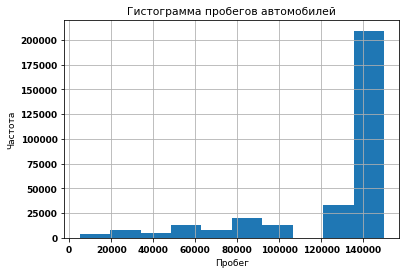

In [45]:
df['Kilometer'].hist()
plt.xlabel('Пробег')
plt.ylabel('Частота')
plt.title('Гистограмма пробегов автомобилей')
plt.show()

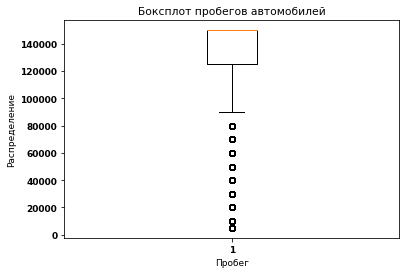

In [46]:
plt.boxplot(df['Kilometer'])
plt.xlabel('Пробег')
plt.ylabel('Распределение')
plt.title('Боксплот пробегов автомобилей')
plt.show()

Ну, в целом данные выглядят прилично, вроде каких-то особых выбросов не вижу

Теперь взглянем на месяц регистрации `RegistrationMonth`

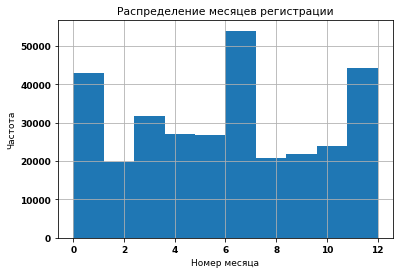

3     31753
6     28970
4     27018
5     26852
7     24971
10    23987
12    22294
11    22046
0     21902
9     21881
1     21127
8     20723
2     19751
Name: RegistrationMonth, dtype: int64

In [47]:
df['RegistrationMonth'].hist()
plt.xlabel('Номер месяца')
plt.ylabel('Частота')
plt.title('Распределение месяцев регистрации')
plt.show()
df['RegistrationMonth'].value_counts()

Как видим, выбросов вроде нет

Теперь посмотрим на `NumberOfPictures`

In [48]:
df['NumberOfPictures'].value_counts()

0    313275
Name: NumberOfPictures, dtype: int64

Тут у нас одни нули, бесполезный столбец

In [49]:
df = df.drop(['NumberOfPictures'], axis = 1)

Удалили его. Рассмотрим теперь аномалии в столбце `DateCreated`

In [50]:
df['DateCreated'].sort_values()

4001      2015-03-20 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
75598     2015-09-04 00:00:00
221002    2015-09-04 00:00:00
                 ...         
39573     2016-04-07 00:00:00
322257    2016-04-07 00:00:00
314002    2016-04-07 00:00:00
187579    2016-04-07 00:00:00
282111    2016-04-07 00:00:00
Name: DateCreated, Length: 313275, dtype: object

Видим, что даты с 2015 по 2016 годы, аномалий нет

Мы еще не рассматривали столбцы `PostalCode`, `LastSeen` и `DateCrawled` - они вряд ли будут полезными для предсказаний, поэтому удалим их на всякий случай

In [51]:
df = df.drop(['PostalCode', 'LastSeen', 'DateCrawled'], axis = 1)

Избавились от них

### Типы данных
Рассмотрим типы данных нашего датафрейма

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313275 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              313275 non-null  int64 
 1   VehicleType        313275 non-null  object
 2   RegistrationYear   313275 non-null  int64 
 3   Gearbox            313275 non-null  object
 4   Power              313275 non-null  int64 
 5   Model              313275 non-null  object
 6   Kilometer          313275 non-null  int64 
 7   RegistrationMonth  313275 non-null  int64 
 8   FuelType           313275 non-null  object
 9   Brand              313275 non-null  object
 10  Repaired           313275 non-null  object
 11  DateCreated        313275 non-null  object
dtypes: int64(5), object(7)
memory usage: 31.1+ MB


Единственное, что смущает - тип `object` у столбца с датой создания анкеты. Поменяем его на временной тип

In [53]:
df['DateCreated'] = pd.to_datetime(
    df['DateCreated'], format='%Y-%m-%d %H:%M:%S'
)


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313275 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              313275 non-null  int64         
 1   VehicleType        313275 non-null  object        
 2   RegistrationYear   313275 non-null  int64         
 3   Gearbox            313275 non-null  object        
 4   Power              313275 non-null  int64         
 5   Model              313275 non-null  object        
 6   Kilometer          313275 non-null  int64         
 7   RegistrationMonth  313275 non-null  int64         
 8   FuelType           313275 non-null  object        
 9   Brand              313275 non-null  object        
 10  Repaired           313275 non-null  object        
 11  DateCreated        313275 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 31.1+ MB


Тип этого столбца успешно изменили

### Новый столбец
Рассмотрим возраст машин и подумаем, что можем сделать для улучшения предсказаний

<AxesSubplot:>

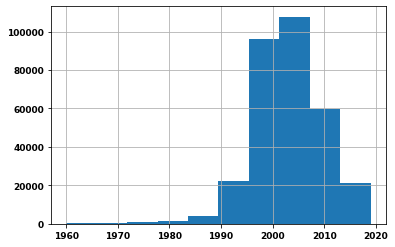

In [55]:
df['RegistrationYear'].hist()

Видим, что у нас машины с 1960 по 2020 годы, разобьём на несколько групп:
- retro (старше 1980 года)
- old (старше 2000 года)
- medium_age (старше 2010 года)
- normal_age (старше 2015 года)
- new (с 2015 по настоящее время)

In [56]:
def get_auto_rank(df):
    df['auto_age'] = 'unknown'
    return np.select(
    condlist = (
    df['RegistrationYear'] < 1980,
    df['RegistrationYear'] < 2000,
    df['RegistrationYear'] < 2010, 
    df['RegistrationYear'] < 2015,
    df['RegistrationYear'] >= 2015,),
    choicelist = ('retro', 'old','medium_age','normal_age','new'),
    default = 'unknown')

In [57]:
df = df.assign(auto_age = lambda df_: get_auto_rank(df))

In [58]:
df['auto_age'].value_counts()

medium_age    173826
old            85358
normal_age     33367
new            18593
retro           2131
Name: auto_age, dtype: int64

Отлично, мы добавили новый столбец с типом возраста машин, в котором, как видим, больше всего машин "среднего возраста" (с 2000 по 2010 годы), меньше всего ретро-машин (старше 1980 года). Выглядит столбец вполне прилично

### Аномалии в целевом признаке
Рассмотрим аномалии в целевом признаке (цена автомобиля)

<AxesSubplot:>

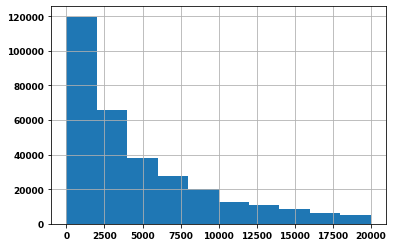

In [59]:
df['Price'].hist()

In [60]:
df['Price'].describe()

count    313275.000000
mean       4703.034905
std        4587.878745
min           0.000000
25%        1250.000000
50%        2999.000000
75%        6880.000000
max       20000.000000
Name: Price, dtype: float64

In [61]:
df.query('Price <= 200')['Price'].count()

12171

Все цены у нас в евро, при этом почти 20000 автомобилей торгуются по цене меньше, чем 200 евро. Я бы на всякий случай избавился от таких данных, так как опять же, слишком много авто с чрезвычайно низкой стоимостью

In [62]:
df = df.query('Price > 200')

### Промежуточный итог 1.1

Мы произвели загрузку датафрейма и предобработку данных - разобрались с:
- пропусками (они были в пяти столбцах)
    - Repaired -        20.08 %
    - VehicleType -    10.58 %
    - FuelType -        9.28 %
    - Gearbox -         5.6 %
    - Model -           5.56 %
    Заполнять старались на основании анализа других данных датафрейма, если не было возможности - ставили заглушку `unknown`
- аномалиями (были аномалии в годе выпуска автомобилей и мощности)
- дубликатами (их было 5 штук)
- Проследили типы данных в датафрейме (необходимо было заменить только вещественный тип столбца `DateCreated` на временной)
- Избавились от бесполезных столбцов `NumberOfPictures`,`PostalCode`, `LastSeen` и `DateCrawled`, которые не помогли бы нам помочь в предсказаниях, а только бы мешали модели, замедляя её
- Добавили новый столбец с типом возраста автомобиля
- Проанализировали аномалии в целевом признаке (цена авто)

### Разобьём данные на выборки
Необходимо разбить данные на признаки и целевой признак, а также на три выборки: обучающую, валидационную и тестовую в соотношении 3:1:1

In [63]:
# сначала выделим признаки и целевой признак
target = df['Price'] # целевой признак
features = df.drop('Price', axis = 1) # признаки

In [64]:
# сначала разобьём даныне в соотношении 4:1, выделяя тренировочно-валидационную и тестовую выборку
features_train_valid, features_test, target_train_valid, target_test = \
    train_test_split(features, target, test_size=0.2, random_state=12345)
# теперь тренировочно-валидацинную выборку разобьём на тренировочную и валидационную (необходимо будет поделить её в соотношении
# 3:1, чтобы получить итоговые соотношения трёх выборок 3:1:1
features_train, features_valid, target_train, target_valid = \
    train_test_split(features_train_valid, target_train_valid, test_size=0.25, random_state=12345)

Проверим соотношения их размеров

In [65]:
print(f'Тренировочная выборка признаков в {features_train.shape[0]/features_valid.shape[0]}\
 раза больше валидационной и в {features_train.shape[0]/features_test.shape[0]} раза больше тестовой')
print(f'Тренировочная выборка целевого признака в {target_train.shape[0]/target_valid.shape[0]}\
 раза больше валидационной и в {target_train.shape[0]/target_valid.shape[0]} раза больше тестовой')

Тренировочная выборка признаков в 2.9999833944969363 раза больше валидационной и в 2.9999833944969363 раза больше тестовой
Тренировочная выборка целевого признака в 2.9999833944969363 раза больше валидационной и в 2.9999833944969363 раза больше тестовой


Данные разбились хорошо

### Преобразуем данные
#### Кодирование
Будем использовать порядковое кодирование, так как у нас много категориальных данных + мы будем работать с модедями деревьев решений 

In [66]:
# пришлось использовать гиперпараметры `handle_unknown` и `unknown_value`
# потому что на следующем шаге (при трансформации) выдает ошибку
# благодаря этим гиперпараметрам все ошибки не выводятся, а заполняются значением `-1`
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Теперь можно трансформировать признаки (не забываем сразу вернуть тип датафрейма к нашим данным)

In [67]:
features_train_encoded = pd.DataFrame(encoder.transform(features_train), columns = features_train.columns)
features_valid_encoded = pd.DataFrame(encoder.transform(features_valid), columns = features_valid.columns)
features_test_encoded = pd.DataFrame(encoder.transform(features_test), columns = features_test.columns)

Проверим

In [68]:
features_train_encoded.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,auto_age
0,7.0,57.0,1.0,104.0,51.0,12.0,11.0,5.0,38.0,0.0,84.0,1.0
1,4.0,42.0,1.0,105.0,11.0,12.0,10.0,5.0,2.0,1.0,79.0,0.0
2,8.0,45.0,1.0,213.0,31.0,12.0,7.0,5.0,1.0,1.0,94.0,0.0
3,0.0,38.0,1.0,81.0,223.0,12.0,6.0,5.0,38.0,1.0,82.0,3.0
4,5.0,39.0,1.0,44.0,166.0,12.0,7.0,6.0,12.0,0.0,92.0,3.0


In [69]:
features_valid_encoded.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,auto_age
0,4.0,37.0,1.0,105.0,42.0,10.0,1.0,5.0,24.0,0.0,61.0,3.0
1,5.0,49.0,1.0,49.0,173.0,7.0,3.0,5.0,38.0,0.0,90.0,0.0
2,7.0,56.0,0.0,97.0,33.0,12.0,1.0,5.0,20.0,0.0,74.0,1.0
3,7.0,58.0,1.0,90.0,234.0,12.0,10.0,6.0,24.0,0.0,76.0,1.0
4,4.0,42.0,1.0,114.0,219.0,12.0,3.0,5.0,30.0,0.0,79.0,0.0


In [70]:
features_test_encoded.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,auto_age
0,5.0,40.0,1.0,49.0,176.0,12.0,12.0,5.0,9.0,0.0,78.0,0.0
1,5.0,40.0,1.0,64.0,75.0,12.0,12.0,5.0,27.0,0.0,73.0,0.0
2,7.0,56.0,1.0,64.0,149.0,12.0,0.0,5.0,27.0,0.0,86.0,1.0
3,0.0,54.0,1.0,111.0,47.0,2.0,3.0,5.0,20.0,0.0,73.0,2.0
4,4.0,45.0,1.0,91.0,116.0,9.0,7.0,5.0,38.0,0.0,65.0,0.0


Как видим, все хорошо закодировалось, теперь необходимо отмасштабировать

#### Масштабирование
Не забудем также вернуть структуру датафрейма

In [71]:
scaler = StandardScaler()
scaler.fit(features_train_encoded)

StandardScaler()

In [72]:
features_train_scaled = pd.DataFrame(scaler.transform(features_train_encoded), columns=features_train_encoded.columns)
features_valid_scaled = pd.DataFrame(scaler.transform(features_valid_encoded), columns=features_valid_encoded.columns)
features_test_scaled = pd.DataFrame(scaler.transform(features_test_encoded), columns=features_test_encoded.columns)

Проверим

In [73]:
features_train_scaled.head() 

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,auto_age
0,0.977146,1.994280,0.432643,-0.111413,-0.846283,0.514483,1.396337,-0.017286,1.286197,-0.317847,0.668365,-0.063465
1,-0.264323,-0.207445,0.432643,-0.092372,-1.392816,0.514483,1.117589,-0.017286,-1.400471,3.146165,0.127745,-0.815213
2,1.390969,0.232900,0.432643,1.964076,-1.119550,0.514483,0.281345,-0.017286,-1.475101,3.146165,1.749605,-0.815213
3,-1.919614,-0.794572,0.432643,-0.549361,1.503813,0.514483,0.002597,-0.017286,1.286197,3.146165,0.452117,1.440033
4,0.149500,-0.647790,0.432643,-1.253885,0.725002,0.514483,0.281345,2.433968,-0.654175,-0.317847,1.533357,1.440033


In [74]:
features_valid_scaled.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,auto_age
0,-0.264323,-0.941354,0.432643,-0.092372,-0.969253,-0.263431,-1.391144,-0.017286,0.241381,-0.317847,-1.818486,1.440033
1,0.149500,0.820027,0.432643,-1.158679,0.820646,-1.430302,-0.833648,-0.017286,1.286197,-0.317847,1.317109,-0.815213
2,0.977146,1.847499,-1.918240,-0.244702,-1.092223,0.514483,-1.391144,-0.017286,-0.057137,-0.317847,-0.412874,-0.063465
3,0.977146,2.141062,0.432643,-0.377990,1.654110,0.514483,1.117589,2.433968,0.241381,-0.317847,-0.196627,-0.063465
4,-0.264323,-0.207445,0.432643,0.078998,1.449160,0.514483,-0.833648,-0.017286,0.689159,-0.317847,0.127745,-0.815213


In [75]:
features_test_scaled.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,auto_age
0,0.149500,-0.501009,0.432643,-1.158679,0.861636,0.514483,1.675085,-0.017286,-0.878064,-0.317847,0.019621,-0.815213
1,0.149500,-0.501009,0.432643,-0.873061,-0.518362,0.514483,1.675085,-0.017286,0.465270,-0.317847,-0.520998,-0.815213
2,0.977146,1.847499,0.432643,-0.873061,0.492726,0.514483,-1.669892,-0.017286,0.465270,-0.317847,0.884613,-0.063465
3,-1.919614,1.553935,0.432643,0.021875,-0.900936,-3.375086,-0.833648,-0.017286,-0.057137,-0.317847,-0.520998,0.688284
4,-0.264323,0.232900,0.432643,-0.358949,0.041835,-0.652388,0.281345,-0.017286,1.286197,-0.317847,-1.385990,-0.815213


Видим, все отмасштабировано

### Матрица корреляции признаков
Проверим, есть ли у нас проблема мультиколлинеарности

In [76]:
def show_corr_matrix(dataset, features, corr_method='pearson', figsize=(10, 10)):
    corr_matrix = dataset[features].corr(method=corr_method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        vmin=-1.,
        vmax=1.,
        annot=True,
        linewidths= 1.0,
        cmap='coolwarm'
    )
    plt.show()

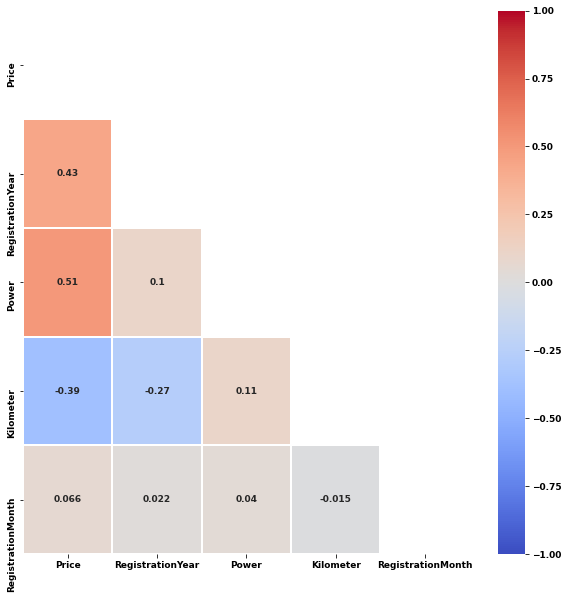

In [77]:
show_corr_matrix(df[df.select_dtypes(exclude=['object']).columns], 
                 df.select_dtypes(exclude=['object']).columns)

Видно, что есть средняя положительная корреляция между мощностью и ценой, а также между годом регистрации и ценой
Удалять эти столбцы не очень хочется, так как все-таки они очень важны для прогнозирования цены, что как раз и отражается в матрице корреляций.

Также довольно логично выглядит средняя отрицательная корреляции пробега и цены (чем выше пробег, тем ниже цена)

### Промежуточный итог 1.2.
Мы проработали подготовленные данные: 
- разбили их на признаки и на целевой признак
- разделили на три выборки: тренировочную, валидационную и тестовую в соотношении 3:1:1
- закодировали и отмасштабировали эти выборки
- провели анализ проблемы мультиколлинеарности
    - Видно, что есть средняя положительная корреляция между мощностью и ценой, а также между годом регистрации и ценой Удалять эти столбцы не очень хочется, так как все-таки они очень важны для прогнозирования цены, что как раз и отражается в матрице корреляций.

    - Также довольно логично выглядит средняя отрицательная корреляции пробега и цены (чем выше пробег, тем ниже цена)

## Обучение моделей
Теперь необходимо обучить разные модели и выбрать лучшую по значению `RMSE`

### Случайный лес
Начнем с модели случайного леса. Время выполнения операций будем получать с помощью команды `%%time`

In [78]:
RFR = RandomForestRegressor(random_state=12345)

Посмотрим на возможные гиперпараметры

In [79]:
pd.Series(RFR.get_params().keys()) 

0                    bootstrap
1                    ccp_alpha
2                    criterion
3                    max_depth
4                 max_features
5               max_leaf_nodes
6                  max_samples
7        min_impurity_decrease
8           min_impurity_split
9             min_samples_leaf
10           min_samples_split
11    min_weight_fraction_leaf
12                n_estimators
13                      n_jobs
14                   oob_score
15                random_state
16                     verbose
17                  warm_start
dtype: object

Пока мудрить не будем, тем более данных очень много, возьмем только гиперпараметры `max_depth` и `n_estimators`
Искать лучшие будем с помощью `GridSearcCV`

In [80]:
GSCV = GridSearchCV( RFR, {
        "max_depth": [1, 5, 10],
        'n_estimators': range (1, 102, 50)
}, 
    cv = 3, # количество разбиений на кросс-валидацию ( < 3 делать не стоит) 
    scoring = 'neg_mean_squared_error') # как мы будем оценивать модель

In [81]:
%%time
GSCV.fit(features_train_scaled, target_train)

CPU times: user 4min 1s, sys: 232 ms, total: 4min 1s
Wall time: 4min 3s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': range(1, 102, 50)},
             scoring='neg_mean_squared_error')

Взглянем, какие значения гиперпараметров лучше всего проявили себя

In [82]:
GSCV.best_params_

{'max_depth': 10, 'n_estimators': 101}

Теперь обучим модель случайного леса на этих гиперпараметрах и сделаем предсказания, на основе которых рассчитаем значение `RMSE`

In [83]:
best_RFR = RandomForestRegressor(max_depth = 10, n_estimators = 101, random_state=12345)

Обучим модель и получим время обучения

In [84]:
%%time
best_RFR.fit(features_train_scaled, target_train)

CPU times: user 41.6 s, sys: 28.6 ms, total: 41.6 s
Wall time: 41.7 s


RandomForestRegressor(max_depth=10, n_estimators=101, random_state=12345)

Сделаем предсказание и получим время предсказания

In [85]:
%%time
# не забываем, что нам необходимо фиксировать время предсказания
predicted_target_valid = best_RFR.predict(features_valid_scaled)

CPU times: user 594 ms, sys: 0 ns, total: 594 ms
Wall time: 601 ms


In [86]:
print('RMSE', mean_squared_error(predicted_target_valid, target_valid) ** 0.5)

RMSE 1877.5553286432832


Теперь построим график важности признаков для предсказаний

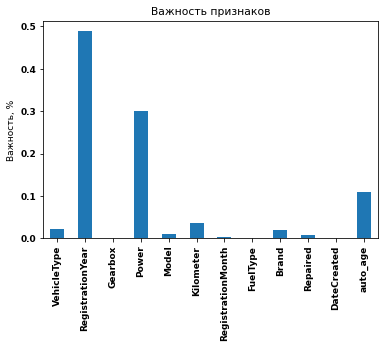

In [87]:
model_imp = pd.Series(best_RFR.feature_importances_,
                         features_train_scaled.columns)
model_imp.plot.bar()
plt.title("Важность признаков")
plt.ylabel('Важность, %')
plt.show()

Хочется взглянуть на то, как важность признаков меняется при разных наборах гиперпараметров

In [88]:
importance_RFR_list = {}
for n_est in range(1, 102, 50):
    for depth in [1, 5, 10]:
        _ = RandomForestRegressor(max_depth = depth, n_estimators = n_est, random_state = 12345)
        _.fit(features_train_scaled, target_train)
        importance_RFR_list[n_est, depth] = (_.feature_importances_)

In [89]:
importance_RFR_df = pd.DataFrame(importance_RFR_list, index=features_train.columns)
importance_RFR_df

1                        51                       101  \
                    1         5         10   1         5         10   1    
VehicleType        0.0  0.011129  0.022824  0.0  0.012870  0.022568  0.0   
RegistrationYear   1.0  0.538943  0.491077  1.0  0.535912  0.489231  1.0   
Gearbox            0.0  0.000000  0.000256  0.0  0.000000  0.000972  0.0   
Power              0.0  0.305841  0.298599  0.0  0.310208  0.301038  0.0   
Model              0.0  0.000000  0.011602  0.0  0.000000  0.010005  0.0   
Kilometer          0.0  0.016157  0.034054  0.0  0.017236  0.035565  0.0   
RegistrationMonth  0.0  0.000000  0.002054  0.0  0.000000  0.002116  0.0   
FuelType           0.0  0.000000  0.000120  0.0  0.000000  0.000329  0.0   
Brand              0.0  0.000000  0.020184  0.0  0.000174  0.019886  0.0   
Repaired           0.0  0.000000  0.007861  0.0  0.000111  0.007736  0.0   
DateCreated        0.0  0.000000  0.001758  0.0  0.000000  0.001672  0.0   
auto_age           0.0  0.127928  0.109613  0.0  0.123489  0.108881  0.0   

                                       
                         5         10  
VehicleType        0.012832  0.022571  
RegistrationYear   0.534851  0.488699  
Gearbox            0.000000  0.000991  
Power              0.310560  0.300856  
Model              0.000000  0.010255  
Kilometer          0.016988  0.035436  
RegistrationMonth  0.000000  0.002099  
FuelType           0.000000  0.000331  
Brand              0.000184  0.019853  
Repaired           0.000101  0.007785  
DateCreated        0.000000  0.001687  
auto_age           0.124483  0.109436

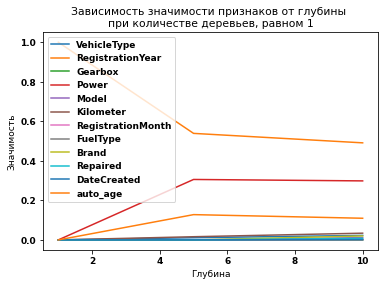

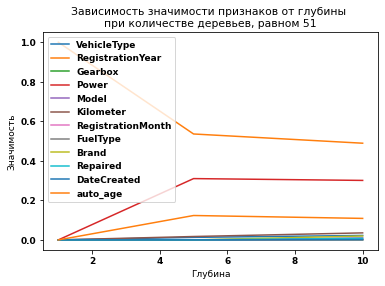

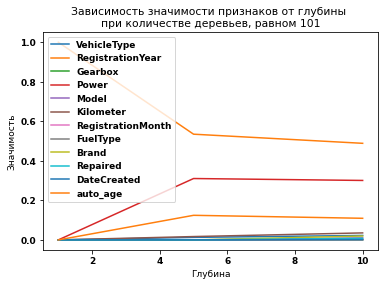

In [90]:
for i in range(1,102,50):    
    importance_RFR_df[i].T.plot()
    plt.title(f'Зависимость значимости признаков от глубины \nпри количестве деревьев, равном {i}')
    plt.xlabel('Глубина')
    plt.ylabel('Значимость')
    plt.show()

#### Промежуточный итог 2.1. 
- Для модели случайного леса мы получили следующие лучшие значения гиперпараметров `max_depth = 10` и `n_estimators = 101`
- Обучив модель с этими гиперпараметрами, мы получили следующее значение `RMSE`, равное `1877.56`
- `fit` этой модели занял время `41.7 s`, а `predict` - `601ms`
- Построив график важности признаков для предсказаний, видим, что самые важные среди всех три `VehicleType`, `Power` и `Kilometer`, что вообще видели на матрице корреляций.  
- При рассмотрении значимостей признаков от глубины и количества деревьев, видно, что вышеупомянутые три признака выходят на плато уже на глубине, равной 3 (при любом количестве деревьев), `VehicleType` начинает чуть-чуть расти (отличаться от 0) где-то на глубине 5, выйдя на плато

### CatBoost
Теперь попробуем модель Catboost. Она работает только с категориальными признаками, не требуя кодировки



In [91]:
cat_features = list(df.select_dtypes(include=['object']).columns) # сохраним названия столбцов, в которых данные типа object
cat_features

['VehicleType',
 'Gearbox',
 'Model',
 'FuelType',
 'Brand',
 'Repaired',
 'auto_age']

Теперь импортируем модель, функция потерь у нас будет наша требуемая метрика `RMSE`, количество итераций поставим 150

In [92]:
CBR = CatBoostRegressor(loss_function="RMSE", iterations=150, cat_features = cat_features) 

In [93]:
CBR.fit(features_train, target_train)

Learning rate set to 0.435113
0:	learn: 3383.1079228	total: 204ms	remaining: 30.4s
1:	learn: 2758.7340494	total: 285ms	remaining: 21.1s
2:	learn: 2444.3071552	total: 387ms	remaining: 19s
3:	learn: 2233.1574165	total: 474ms	remaining: 17.3s
4:	learn: 2146.5568821	total: 578ms	remaining: 16.8s
5:	learn: 2061.5265971	total: 653ms	remaining: 15.7s
6:	learn: 2019.0360775	total: 732ms	remaining: 14.9s
7:	learn: 1987.3301998	total: 814ms	remaining: 14.5s
8:	learn: 1964.5815258	total: 894ms	remaining: 14s
9:	learn: 1942.8889977	total: 985ms	remaining: 13.8s
10:	learn: 1924.3507392	total: 1.06s	remaining: 13.4s
11:	learn: 1908.6198200	total: 1.14s	remaining: 13.1s
12:	learn: 1899.5970531	total: 1.21s	remaining: 12.8s
13:	learn: 1886.5798503	total: 1.29s	remaining: 12.5s
14:	learn: 1873.9258200	total: 1.37s	remaining: 12.3s
15:	learn: 1867.0867570	total: 1.46s	remaining: 12.2s
16:	learn: 1861.9640421	total: 1.53s	remaining: 11.9s
17:	learn: 1854.6720190	total: 1.61s	remaining: 11.8s
18:	learn: 1

In [94]:
%%time
cv_score_rf = cross_val_score(CBR, 
                features_train, 
                target_train,
                scoring='neg_mean_squared_error',                           
                cv=3)

Learning rate set to 0.408112
0:	learn: 3458.7382989	total: 78.4ms	remaining: 11.7s
1:	learn: 2828.6489708	total: 149ms	remaining: 11s
2:	learn: 2504.2722025	total: 202ms	remaining: 9.89s
3:	learn: 2275.8750006	total: 261ms	remaining: 9.54s
4:	learn: 2179.3756717	total: 318ms	remaining: 9.23s
5:	learn: 2106.1856228	total: 375ms	remaining: 8.99s
6:	learn: 2041.1263622	total: 439ms	remaining: 8.97s
7:	learn: 2004.0349258	total: 501ms	remaining: 8.89s
8:	learn: 1985.1583668	total: 591ms	remaining: 9.26s
9:	learn: 1963.9784507	total: 676ms	remaining: 9.46s
10:	learn: 1945.1815748	total: 763ms	remaining: 9.64s
11:	learn: 1932.9366847	total: 835ms	remaining: 9.6s
12:	learn: 1915.8629204	total: 893ms	remaining: 9.41s
13:	learn: 1904.6189246	total: 954ms	remaining: 9.27s
14:	learn: 1895.8510472	total: 1.01s	remaining: 9.11s
15:	learn: 1885.9928679	total: 1.06s	remaining: 8.87s
16:	learn: 1876.1309823	total: 1.12s	remaining: 8.77s
17:	learn: 1870.0621746	total: 1.17s	remaining: 8.59s
18:	learn:

In [95]:
print(f'RMSE для CatBoostRegressor: {np.mean(-cv_score_rf)** 0.5:.2f}')

RMSE для CatBoostRegressor: 1698.12


Для 150 итераций мы получили значение `RMSE` модели `CatBoostRegressor`, равное `1772.46`

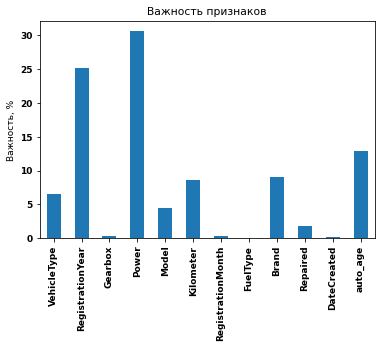

In [96]:
model_imp = pd.Series(CBR.get_feature_importance(),
                         features_train.columns)
model_imp.plot.bar()
plt.title("Важность признаков")
plt.ylabel('Важность, %')
plt.show()

Значимость признаков же для неё уже немного отличается, хотя три главных те же, имеются также несладые значимости у `VehivleType` и `Brand`

Теперь необходимо рассмотреть несколько разных гиперпараметров для этой модели. Почитав документацию, видим, что для `CatBoostRegressor` тоже есть `max_depth` и `n_estimators`

In [97]:
CBR = CatBoostRegressor(loss_function="RMSE", cat_features = cat_features) 

In [98]:
CBR_GSCV = GridSearchCV( CBR, {
    "max_depth": [1, 5, 10],
        'n_estimators': [1, 50, 100, 150]
}, 
    cv = 3) # количество разбиений на кросс-валидацию ( < 3 делать не стоит)

In [99]:
CBR_GSCV.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 4000.3623063	total: 31.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3982.5389087	total: 26ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3988.1947978	total: 30.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 4000.3623063	total: 31.1ms	remaining: 1.52s
1:	learn: 3648.9536110	total: 49.1ms	remaining: 1.18s
2:	learn: 3308.0048794	total: 80ms	remaining: 1.25s
3:	learn: 3157.6910884	total: 98ms	remaining: 1.13s
4:	learn: 3030.8970521	total: 119ms	remaining: 1.07s
5:	learn: 2937.4993219	total: 148ms	remaining: 1.08s
6:	learn: 2838.9969505	total: 166ms	remaining: 1.02s
7:	learn: 2781.2532572	total: 187ms	remaining: 980ms
8:	learn: 2722.0471939	total: 208ms	remaining: 948ms
9:	learn: 2678.0253226	total: 229ms	remaining: 914ms
10:	learn: 2634.1653983	total: 247ms	remaining: 877ms
11:	learn: 2601.6470125	total: 267ms	remaining: 844ms
12:	learn: 2547.6070376	total: 289ms	remaining: 822ms
13:	learn: 2523.4520054	total: 311ms	remaining: 800ms


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd4fcc039d0>,
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [1, 50, 100, 150]})

In [100]:
CBR_GSCV.best_params_

{'max_depth': 10, 'n_estimators': 150}

Теперь необходимо сделать предсказание моделью с этими гиперпараметрами, засечь время и рассчитать RMSE

In [101]:
best_CBR = CatBoostRegressor(loss_function="RMSE", max_depth = 10, n_estimators = 150, cat_features = cat_features)

In [102]:
%%time
best_CBR.fit(features_train, target_train)

Learning rate set to 0.435113
0:	learn: 3259.7761355	total: 168ms	remaining: 25s
1:	learn: 2583.2286326	total: 317ms	remaining: 23.5s
2:	learn: 2243.9726385	total: 462ms	remaining: 22.6s
3:	learn: 2053.5339608	total: 613ms	remaining: 22.4s
4:	learn: 1931.2305109	total: 811ms	remaining: 23.5s
5:	learn: 1874.7423686	total: 967ms	remaining: 23.2s
6:	learn: 1840.6940087	total: 1.18s	remaining: 24.1s
7:	learn: 1820.4411967	total: 1.31s	remaining: 23.3s
8:	learn: 1802.8786135	total: 1.45s	remaining: 22.7s
9:	learn: 1787.9555940	total: 1.58s	remaining: 22.2s
10:	learn: 1774.6456086	total: 1.72s	remaining: 21.8s
11:	learn: 1761.6807311	total: 1.85s	remaining: 21.3s
12:	learn: 1752.8182413	total: 1.99s	remaining: 21s
13:	learn: 1740.6966774	total: 2.13s	remaining: 20.7s
14:	learn: 1731.3280326	total: 2.27s	remaining: 20.5s
15:	learn: 1721.1389817	total: 2.42s	remaining: 20.3s
16:	learn: 1715.6426198	total: 2.56s	remaining: 20s
17:	learn: 1706.4765204	total: 2.7s	remaining: 19.8s
18:	learn: 1698

In [103]:
%%time
prediction_CBR_best = best_CBR.predict(features_valid)

CPU times: user 200 ms, sys: 4.02 ms, total: 204 ms
Wall time: 202 ms


In [104]:
print(f'best RMSE для CatBoostRegressor: {mean_squared_error(prediction_CBR_best, target_valid, squared=False):.2f}')

best RMSE для CatBoostRegressor: 1608.19


Обязательно надо посмотреть на важность признаков

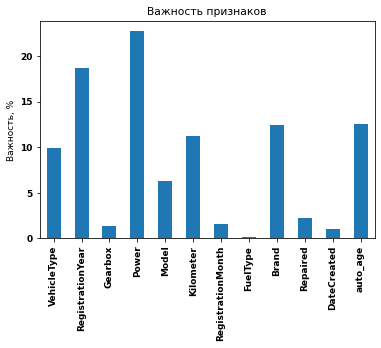

In [105]:
model_imp = pd.Series(best_CBR.get_feature_importance(),
                         features_train.columns)
model_imp.plot.bar()
plt.title("Важность признаков")
plt.ylabel('Важность, %')
plt.show()

Видим, что лидирующая тройка теперь другая, да и вообще многие признаки имеют высокую значимость для предсказаний. Тройка теперь состоит из `RegistrationYear`, `Power` и `VehicleType` (`Brand` тоже очень важен, на уровне с `VehicleType`). Также довольно важны `Kilometer` и `Model`

Посмотрим, как меняется важность признаков в зависимости от гиперпараметров

In [106]:
importance_RFR_list = {}
depths = [1, 5, 10]
estimators = [1, 50, 100, 150, 200]
for n_est in estimators:
    for depth in depths:
        _ = CatBoostRegressor(loss_function="RMSE", max_depth = depth, n_estimators = n_est, cat_features = cat_features)
        _.fit(features_train, target_train)
        importance_RFR_list[n_est, depth] = (_.get_feature_importance())

Learning rate set to 0.5
0:	learn: 3990.3691484	total: 55.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3294.8684523	total: 99.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3092.9131743	total: 164ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3990.3691484	total: 60.9ms	remaining: 2.98s
1:	learn: 3639.8875961	total: 111ms	remaining: 2.66s
2:	learn: 3301.1160317	total: 149ms	remaining: 2.33s
3:	learn: 3150.2366394	total: 176ms	remaining: 2.02s
4:	learn: 3024.3396198	total: 217ms	remaining: 1.95s
5:	learn: 2927.1322898	total: 247ms	remaining: 1.81s
6:	learn: 2824.7512128	total: 277ms	remaining: 1.7s
7:	learn: 2761.6508996	total: 307ms	remaining: 1.61s
8:	learn: 2694.3330536	total: 345ms	remaining: 1.57s
9:	learn: 2649.5262598	total: 372ms	remaining: 1.49s
10:	learn: 2617.9670132	total: 399ms	remaining: 1.41s
11:	learn: 2587.5638932	total: 427ms	remaining: 1.35s
12:	learn: 2567.2376837	total: 454ms	remaining: 1.29s
13:	learn: 2543.0390953	total: 481ms	remaining: 1.24s

In [107]:
importance_CBR_df = pd.DataFrame(importance_RFR_list, index=features_train.columns)
importance_CBR_df

1                                50              \
                      1          5          10         1          5    
VehicleType          0.0   0.000000   0.000000   3.374833   6.485472   
RegistrationYear   100.0  27.620658  19.124816  36.843514  27.522951   
Gearbox              0.0   0.000000   0.000000   0.000000   0.193718   
Power                0.0  45.299143  35.011776  28.459000  31.723768   
Model                0.0   0.000000   0.000000   1.781398   3.279319   
Kilometer            0.0   9.247825  16.958271   5.008132   6.972959   
RegistrationMonth    0.0   0.000000   0.000000   0.062912   0.163358   
FuelType             0.0   0.000000   0.000000   0.074777   0.077377   
Brand                0.0   0.000000   0.000000   3.321743   7.148013   
Repaired             0.0   0.000000   0.000000   1.169358   1.668656   
DateCreated          0.0   0.000000   0.000000   0.000000   0.041021   
auto_age             0.0  17.832374  28.905138  19.904334  14.723387   

                                    100                              150  \
                          10         1          5          10         1    
VehicleType         8.263899   3.324663   6.630141   8.484541   2.991919   
RegistrationYear   22.337358  37.046959  27.276301  21.614414  38.429308   
Gearbox             1.160338   0.036628   0.219931   1.294052   0.033545   
Power              23.640572  28.301537  31.465188  22.966583  29.737194   
Model               4.226420   1.858911   3.633491   5.293598   2.125576   
Kilometer          10.208588   5.018621   7.091888  10.037995   4.560757   
RegistrationMonth   0.641516   0.083022   0.191931   1.070103   0.077013   
FuelType            0.106425   0.073665   0.085153   0.135935   0.084691   
Brand              12.189300   3.374916   7.374127  12.489081   2.715739   
Repaired            2.377185   1.170140   1.646078   2.217203   1.094795   
DateCreated         0.321246   0.000000   0.078428   0.724428   0.013442   
auto_age           14.527153  19.710937  14.307343  13.672068  18.136019   

                                               200                        
                          5          10         1          5          10  
VehicleType         9.259154   9.850361   3.591602   6.961679   9.869398  
RegistrationYear   27.339041  18.671150  36.179040  27.649882  27.037607  
Gearbox             0.284226   1.349101   0.034229   0.356418   1.100246  
Power              30.010552  22.707660  27.851516  29.311173  17.986032  
Model               4.004988   6.289471   3.111095   4.346177   6.161432  
Kilometer           7.411591  11.184759   4.649324   8.240978   8.268626  
RegistrationMonth   0.224989   1.542503   0.090769   0.317735   1.320819  
FuelType            0.089787   0.177341   0.078062   0.082345   0.484752  
Brand               8.045126  12.415382   2.951171   7.373401  12.531812  
Repaired            1.615178   2.206447   1.142853   1.748529   1.971528  
DateCreated         0.085543   1.030352   0.011306   0.106140   0.930942  
auto_age           11.629825  12.575473  20.309033  13.505542  12.336804

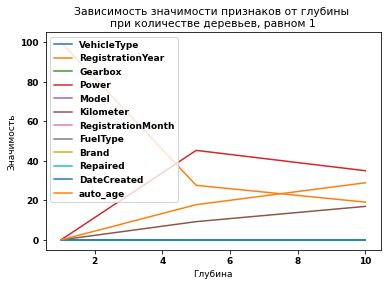

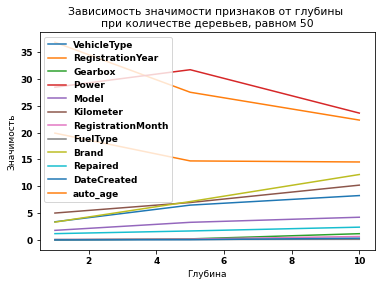

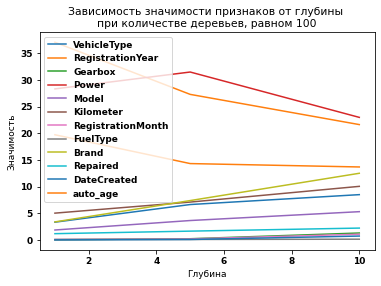

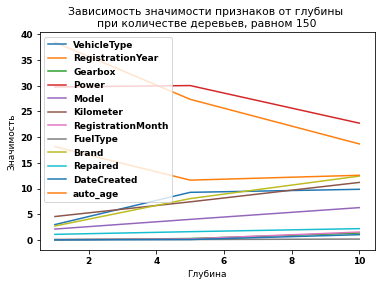

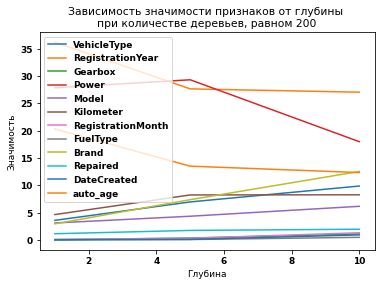

In [108]:
for i in estimators:    
    importance_CBR_df[i].T.plot()
    plt.title(f'Зависимость значимости признаков от глубины \nпри количестве деревьев, равном {i}')
    plt.xlabel('Глубина')
    plt.ylabel('Значимость')
    plt.show()

#### Промежуточный итог 2.2.
Мы рассмотрели модель `CatBoostRegressor` и получили следующие результаты.
- Наилучший `RMSE`, равный `1608.19` достигался при глубине 150 и количестве деревьев 10
- время обучения составляет `23.1 s`, время предсказания `202 ms`
- в принципе очень многие признаки имеют значимость, особенно на количестве деревьев, большем, чем 5
- если рассматривать случай лучшей модели, то видим, что лидирующая тройка теперь другая, да и вообще многие признаки имеют высокую значимость для предсказаний. Тройка теперь состоит из `RegistrationYear`, `Power` и `VehicleType` (`Brand` тоже очень важен, на уровне с `VehicleType`). Также довольно важны `Kilometer` и `Model`. Добавленный нами искусственно столбец `auto_age` имеет неоднозначную, но достаточно высокую значимость вне зависимости от набора гиперпараметров
- если посмотреть зависимость важности признака от гиперпараметров, то 
    - с увеличением глубины растет важность всех признаков, кроме `RegistrationYear` (ещё на количестве деревьев, равном 200, `Power` с увеличением глубины не растет, а падает, хоть и незначительно)
    - с увеличением количества деревьев зависимости особо не меняются, кроме вышеупомянутого `Power`

### LightGBM
Наконец, рассмотрим модель LightGBM. Для начала необходимо сформировать выборки, которые мы будем использовать для обучения нашей модели. Для `LightGBM`, также как и для случайного леса, будем использовать закодированный и отмасштабированные признаки

Теорию брал на этом [сайте](https://lightgbm.readthedocs.io/en/stable/Python-Intro.html)

In [109]:
train_data = lgb.Dataset(features_train_scaled, target_train)
valid_data = lgb.Dataset(features_valid_scaled, target_valid)

Теперь сформируем списки параметров, которые будем изменять. В данной модели также будем менять глубину и количество деревьев

In [110]:
depths = [5, 10]
n_estimators = [10, 25, 50]

Напишем вспомогательную функцию, которая будет возвращать словарь параметров для модели, в котором будут меняться вышеперечисленные гиперпараметры

In [111]:
def parameters(depth = 1, n_estimators = 1):
    return {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 15,
        'max_depth': depth,
        'n_estimators': n_estimators
    }

Теперь пройдемся по всем гиперпараметрам и для каждого обучим модель, сделаем предсказание и рассчитаем `RMSE`, который положим в словарь. Также рассмотрим важность признаков для каждого набора гиперпараметров.

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.391467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.4	valid_1's rmse: 4000.04
[3]	training's rmse: 3791.32	valid_1's rmse: 3770.38
[4]	training's rmse: 3585.67	valid_1's rmse: 3565.63
[5]	training's rmse: 3409.29	valid_1's rmse: 3389.54
[6]	training's rmse: 3253.35	valid_1's rmse: 3234.21
[7]	training's rmse: 3104.7	valid_1's rmse: 3085.73
[8]	training's rmse: 2982.82	valid_1's rmse: 2964.11
[9]	training's rmse: 2871.46	valid_1's rmse: 2853.16
[10]	training's rmse: 2773.74	valid_1's rmse: 2754.69


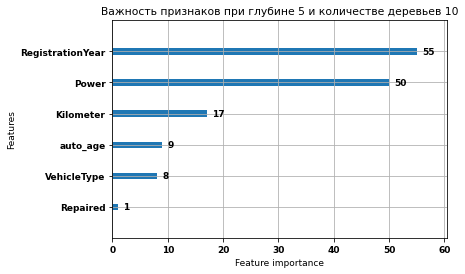

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.4	valid_1's rmse: 4000.04
[3]	training's rmse: 3791.32	valid_1's rmse: 3770.38
[4]	training's rmse: 3585.67	valid_1's rmse: 3565.63
[5]	training's rmse: 3409.29	valid_1's rmse: 3389.54
[6]	training's rmse: 3253.35	valid_1's rmse: 3234.21
[7]	training's rmse: 3104.7	valid_1's rmse: 3085.73
[8]	training's rmse: 2982.82	valid_1's rmse: 2964.11
[9]	training's rmse: 2871.46	valid_1's rmse: 2853.16
[10]	training's rmse: 2773.74	valid_1's rmse: 2754.69
[11]	training's rmse: 2687.52	valid_1's rmse: 2668.64
[12]	

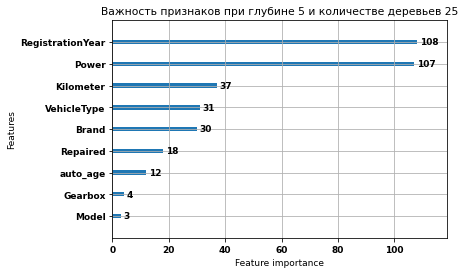

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.4	valid_1's rmse: 4000.04
[3]	training's rmse: 3791.32	valid_1's rmse: 3770.38
[4]	training's rmse: 3585.67	valid_1's rmse: 3565.63
[5]	training's rmse: 3409.29	valid_1's rmse: 3389.54
[6]	training's rmse: 3253.35	valid_1's rmse: 3234.21
[7]	training's rmse: 3104.7	valid_1's rmse: 3085.73
[8]	training's rmse: 2982.82	valid_1's rmse: 2964.11
[9]	training's rmse: 2871.46	valid_1's rmse: 2853.16
[10]	training's rmse: 2773.74	valid_1's rmse: 2754.69
[11]	training's rmse: 2687.52	valid_1's rmse: 2668.64
[12]	

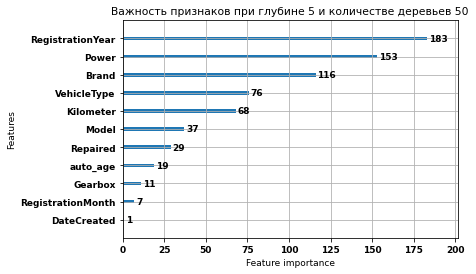

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.04	valid_1's rmse: 3999.62
[3]	training's rmse: 3790.08	valid_1's rmse: 3769.36
[4]	training's rmse: 3584.31	valid_1's rmse: 3564.44
[5]	training's rmse: 3406.83	valid_1's rmse: 3387.15
[6]	training's rmse: 3245.42	valid_1's rmse: 3225.87
[7]	training's rmse: 3100.37	valid_1's rmse: 3081.3
[8]	training's rmse: 2980.49	valid_1's rmse: 2962.32
[9]	training's rmse: 2869.09	valid_1's rmse: 2850.43
[10]	training's rmse: 2772.66	valid_1's rmse: 2754.24


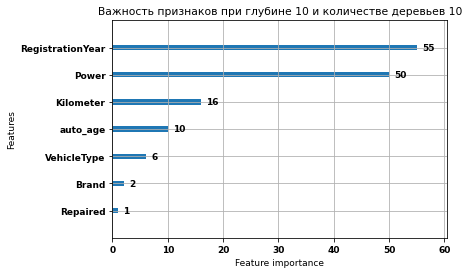

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.488927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.04	valid_1's rmse: 3999.62
[3]	training's rmse: 3790.08	valid_1's rmse: 3769.36
[4]	training's rmse: 3584.31	valid_1's rmse: 3564.44
[5]	training's rmse: 3406.83	valid_1's rmse: 3387.15
[6]	training's rmse: 3245.42	valid_1's rmse: 3225.87
[7]	training's rmse: 3100.37	valid_1's rmse: 3081.3
[8]	training's rmse: 2980.49	valid_1's rmse: 2962.32
[9]	training's rmse: 2869.09	valid_1's rmse: 2850.43
[10]	training's rmse: 2772.66	valid_1's rmse: 2754.24
[11]	training's rmse: 2686.12	valid_1's rmse: 2666.79
[12]

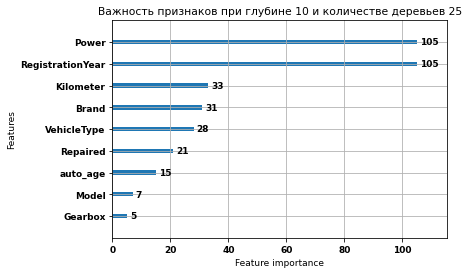

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.379957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.04	valid_1's rmse: 3999.62
[3]	training's rmse: 3790.08	valid_1's rmse: 3769.36
[4]	training's rmse: 3584.31	valid_1's rmse: 3564.44
[5]	training's rmse: 3406.83	valid_1's rmse: 3387.15
[6]	training's rmse: 3245.42	valid_1's rmse: 3225.87
[7]	training's rmse: 3100.37	valid_1's rmse: 3081.3
[8]	training's rmse: 2980.49	valid_1's rmse: 2962.32
[9]	training's rmse: 2869.09	valid_1's rmse: 2850.43
[10]	training's rmse: 2772.66	valid_1's rmse: 2754.24
[11]	training's rmse: 2686.12	valid_1's rmse: 2666.79
[12]	training's rmse: 2613.49	valid_1's rmse: 2594.4
[13]	training's

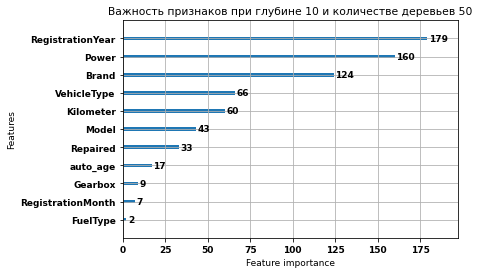

In [115]:
predictions_acc = {}

for depth in depths:
    for n_est in n_estimators:
        model_lgb = lgb.train(parameters(depth, n_est),
                        train_data,
                        num_boost_round=1000,
                        valid_sets=[train_data, valid_data])
        prediction = model_lgb.predict(features_valid_scaled)
        rmse = mean_squared_error(prediction, target_valid, squared=False)
        predictions_acc[depth, n_est] = rmse
        lgb.plot_importance(model_lgb)
        plt.title(f'Важность признаков при глубине {depth} и количестве деревьев {n_est}')
        plt.show()


Выводы по важности признаков напишем в конце, сейчас рассмотрим словарь с рассчитанными значениями `RMSE`

In [116]:
predictions_acc

{(5, 10): 2754.6909847839506,
 (5, 25): 2123.5034253614726,
 (5, 50): 1910.6345114308244,
 (10, 10): 2754.237409624443,
 (10, 25): 2112.579089475015,
 (10, 50): 1887.9796405271852}

Видим, что минимальный `RMSE` достигается при значении глубины 10, а количества деревьев 50. Теперь необходимо обучить модель на этих гиперпараметрах и получить время обучения, а также время предсказания

In [117]:
%%time
model_lgb = lgb.train(parameters(10, 50),
                        train_data,
                        num_boost_round=1000,
                        valid_sets=[train_data, valid_data])


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.389082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 180662, number of used features: 12
[LightGBM] [Info] Start training from score 4901.182756
[1]	training's rmse: 4286.13	valid_1's rmse: 4262.99
[2]	training's rmse: 4022.04	valid_1's rmse: 3999.62
[3]	training's rmse: 3790.08	valid_1's rmse: 3769.36
[4]	training's rmse: 3584.31	valid_1's rmse: 3564.44
[5]	training's rmse: 3406.83	valid_1's rmse: 3387.15
[6]	training's rmse: 3245.42	valid_1's rmse: 3225.87
[7]	training's rmse: 3100.37	valid_1's rmse: 3081.3
[8]	training's rmse: 2980.49	valid_1's rmse: 2962.32
[9]	training's rmse: 2869.09	valid_1's rmse: 2850.43
[10]	training's rmse: 2772.66	valid_1's rmse: 2754.24
[11]	training's rmse: 2686.12	valid_1's rmse: 2666.79
[12]	training's rmse: 2613.49	valid_1's rmse: 2594.4
[13]	training's

In [118]:
%%time
model_lgb.predict(features_valid_scaled)

CPU times: user 255 ms, sys: 3.72 ms, total: 259 ms
Wall time: 285 ms


array([2116.19235588, 5642.87574979, 2828.76401991, ..., 9629.04140879,
       2560.50998528, 2261.69030007])

#### Промежуточный итог 2.3.
Мы рассмотрели модель LightGBM и получили следующие результаты?
- минимальный `RMSE` равен `1887.98`, достигается при следующих гиперпараметрах:
    {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'max_depth': 10,
        'n_estimators': 50
    }
- `время обучения` составляет `2min 15s`, `предсказание` - `285 ms`
- самые важные признаки при данном наборе гиперпараметров: `RegistrationYear`, `Power` и `Brand`, при этом явно выделяется шесть признаков, остальные не очень значительные
- при увеличении количества деревьев меняется (позиционно) значимость всех признаков, кроме `RegistrationYear` и `Power`
- при увеличении глубины меняется как значимость, так и порядок признаков, опять же, кроме вышеперечисленных двух

## Анализ моделей
Рассмотрим, что мы имеем по нашим моделям:

#### Случайный лес. 
- Для модели случайного леса мы получили следующие лучшие значения гиперпараметров `max_depth = 10` и `n_estimators = 101`
- Обучив модель с этими гиперпараметрами, мы получили следующее значение `RMSE`, равное `1877.56`
- `fit` этой модели занял время `41.7 s`, а `predict` - `601ms`
- Построив график важности признаков для предсказаний, видим, что самые важные среди всех три `VehicleType`, `Power` и `Kilometer`, что вообще видели на матрице корреляций.  
- При рассмотрении значимостей признаков от глубины и количества деревьев, видно, что вышеупомянутые три признака выходят на плато уже на глубине, равной 3 (при любом количестве деревьев), `VehicleType` начинает чуть-чуть расти (отличаться от 0) где-то на глубине 5, выйдя на плато

#### CatBoost.
Мы рассмотрели модель `CatBoostRegressor` и получили следующие результаты.
- Наилучший `RMSE`, равный `1608.19` достигался при глубине 150 и количестве деревьев 10
- время обучения составляет `23.1 s`, время предсказания `202 ms`
- в принципе очень многие признаки имеют значимость, особенно на количестве деревьев, большем, чем 5
- если рассматривать случай лучшей модели, то видим, что лидирующая тройка теперь другая, да и вообще многие признаки имеют высокую значимость для предсказаний. Тройка теперь состоит из `RegistrationYear`, `Power` и `VehicleType` (`Brand` тоже очень важен, на уровне с `VehicleType`). Также довольно важны `Kilometer` и `Model`. Добавленный нами искусственно столбец `auto_age` имеет неоднозначную, но достаточно высокую значимость вне зависимости от набора гиперпараметров
- если посмотреть зависимость важности признака от гиперпараметров, то 
    - с увеличением глубины растет важность всех признаков, кроме `RegistrationYear` (ещё на количестве деревьев, равном 200, `Power` с увеличением глубины не растет, а падает, хоть и незначительно)
    - с увеличением количества деревьев зависимости особо не меняются, кроме вышеупомянутого `Power`

#### LightGBM.
Мы рассмотрели модель LightGBM и получили следующие результаты?
- минимальный `RMSE` равен `1887.98`, достигается при следующих гиперпараметрах:
    {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'max_depth': 10,
        'n_estimators': 50
    }
- `время обучения` составляет `2min 15s`, `предсказание` - `285 ms`
- самые важные признаки при данном наборе гиперпараметров: `RegistrationYear`, `Power` и `Brand`, при этом явно выделяется шесть признаков, остальные не очень значительные
- при увеличении количества деревьев меняется (позиционно) значимость всех признаков, кроме `RegistrationYear` и `Power`
- при увеличении глубины меняется как значимость, так и порядок признаков, опять же, кроме вышеперечисленных двух

Что видим? По всем показателям (и `RMSE`, и времена обучения и прогнозирования) выигрывает модель `CatBoostRegressor` с глубиной 150 и количеством деревьев 10. Проверим её на тестовой выборке

In [119]:
%%time
best_CBR.fit(features_train, target_train)

Learning rate set to 0.435113
0:	learn: 3259.7761355	total: 184ms	remaining: 27.4s
1:	learn: 2583.2286326	total: 350ms	remaining: 25.9s
2:	learn: 2243.9726385	total: 511ms	remaining: 25s
3:	learn: 2053.5339608	total: 687ms	remaining: 25.1s
4:	learn: 1931.2305109	total: 846ms	remaining: 24.5s
5:	learn: 1874.7423686	total: 990ms	remaining: 23.8s
6:	learn: 1840.6940087	total: 1.15s	remaining: 23.5s
7:	learn: 1820.4411967	total: 1.29s	remaining: 22.9s
8:	learn: 1802.8786135	total: 1.51s	remaining: 23.6s
9:	learn: 1787.9555940	total: 1.73s	remaining: 24.2s
10:	learn: 1774.6456086	total: 1.93s	remaining: 24.4s
11:	learn: 1761.6807311	total: 2.11s	remaining: 24.2s
12:	learn: 1752.8182413	total: 2.26s	remaining: 23.8s
13:	learn: 1740.6966774	total: 2.43s	remaining: 23.6s
14:	learn: 1731.3280326	total: 2.58s	remaining: 23.3s
15:	learn: 1721.1389817	total: 2.75s	remaining: 23s
16:	learn: 1715.6426198	total: 2.92s	remaining: 22.9s
17:	learn: 1706.4765204	total: 3.07s	remaining: 22.5s
18:	learn: 1

In [120]:
%%time
prediction_test_CBR_best = best_CBR.predict(features_test)

CPU times: user 181 ms, sys: 3.94 ms, total: 185 ms
Wall time: 187 ms


In [121]:
print(f'best RMSE тестовой выборки для CatBoostRegressor: {mean_squared_error(prediction_CBR_best, target_valid, squared=False):.2f}')

best RMSE тестовой выборки для CatBoostRegressor: 1608.19


### Промежуточный итог 3
Мы выяснили, что по всем показателям (и `RMSE`, и времена обучения и прогнозирования) выигрывает модель `CatBoostRegressor` с глубиной 150 и количеством деревьев 10. Проверили её на тестовой выборке.

- Получили значение `RMSE`, равное `1608.19` - нас более, чем устраивает.
- Время обучения составило 23.4 с.
- Время предсказания составило 185 мс.

**Итоговый итог**

Модель `CatBoostRegressor` с глубиной 150 и количеством деревьев 10 обладает хорошими свойствами скорости и предсказательной способности цены автомобиля по данным нашего датафрейма + есть большой плюс в том, что нет никакой необходимости в кодировке и масштабировании данных для этой модели, что вносит ещё один элемент скорости и удобства.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей